In [ ]:
pip install pandas numpy scikit-learn statsmodels matplotlib seaborn geopandas esda libpysal contextily


 Required Libraries

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from esda.moran import Moran_Local
import libpysal
from sklearn.metrics import classification_report, confusion_matrix
from libpysal.weights import DistanceBand
import contextily as ctx

In [ ]:
import contextily as ctx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = pd.read_csv('ICR_Data.csv')
print(data.head())

   OBJECTID  INCIDENT_ID         OFFENSE_ID  OFFENSE_CODE  \
0         1   2020454617   2020454617299900          2999   
1         2  20206013877  20206013877299900          2999   
2         3    202210816    202210816299900          2999   
3         4   2021159354   2021159354299900          2999   
4         5   2020470873   2020470873299900          2999   

   OFFENSE_CODE_EXTENSION          OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
0                       0  criminal-mischief-other     public-disorder   
1                       0  criminal-mischief-other     public-disorder   
2                       0  criminal-mischief-other     public-disorder   
3                       0  criminal-mischief-other     public-disorder   
4                       0  criminal-mischief-other     public-disorder   

  FIRST_OCCURRENCE_DATE        REPORTED_DATE           INCIDENT_ADDRESS  \
0   2020-07-26 16:00:00  2020-07-27 22:09:00        15987 E RANDOLPH PL   
1   2020-10-10 04:55:00  2020-10-14 15

 # Random Forest Regression

In [ ]:
# Convert date
data['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(data['FIRST_OCCURRENCE_DATE'])
# Convert date
data['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(data['FIRST_OCCURRENCE_DATE'])

# Binary label: 0 if 1 victim, 1 if more
data['VICTIM_BIN'] = (data['VICTIM_COUNT'] > 1).astype(int)

# Feature Engineering
data['hour'] = data['FIRST_OCCURRENCE_DATE'].dt.hour
data['dayofweek'] = data['FIRST_OCCURRENCE_DATE'].dt.dayofweek
data['month'] = data['FIRST_OCCURRENCE_DATE'].dt.month

# Encode categorical columns
data['NEIGHBORHOOD_ID'] = data['NEIGHBORHOOD_ID'].astype('category').cat.codes
data['OFFENSE_CATEGORY_ID'] = data['OFFENSE_CATEGORY_ID'].astype('category').cat.codes

# Features and target
X = data[['GEO_LAT', 'GEO_LON', 'hour', 'dayofweek', 'month', 'NEIGHBORHOOD_ID', 'OFFENSE_CATEGORY_ID']]
y = data['VICTIM_BIN']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict & Evaluate
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



[[76874    98]
 [  996    11]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76972
           1       0.10      0.01      0.02      1007

    accuracy                           0.99     77979
   macro avg       0.54      0.50      0.51     77979
weighted avg       0.98      0.99      0.98     77979



 Metrics: MAE & RMSE

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.0140
Root Mean Squared Error (RMSE): 0.1184


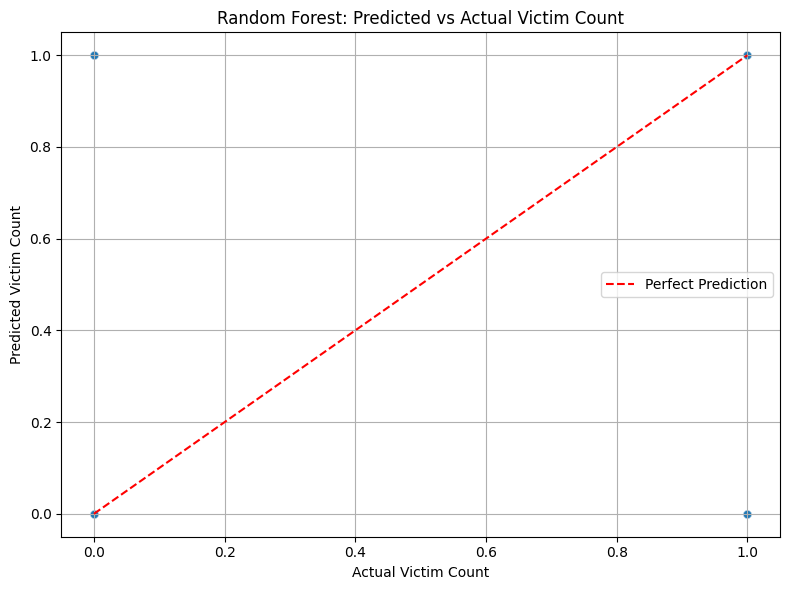

In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Victim Count")
plt.ylabel("Predicted Victim Count")
plt.title("Random Forest: Predicted vs Actual Victim Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# ARIMA Time Series Forecasting

<ipython-input-9-c4eef0479655>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_crimes = data.set_index('FIRST_OCCURRENCE_DATE').resample('M').size()


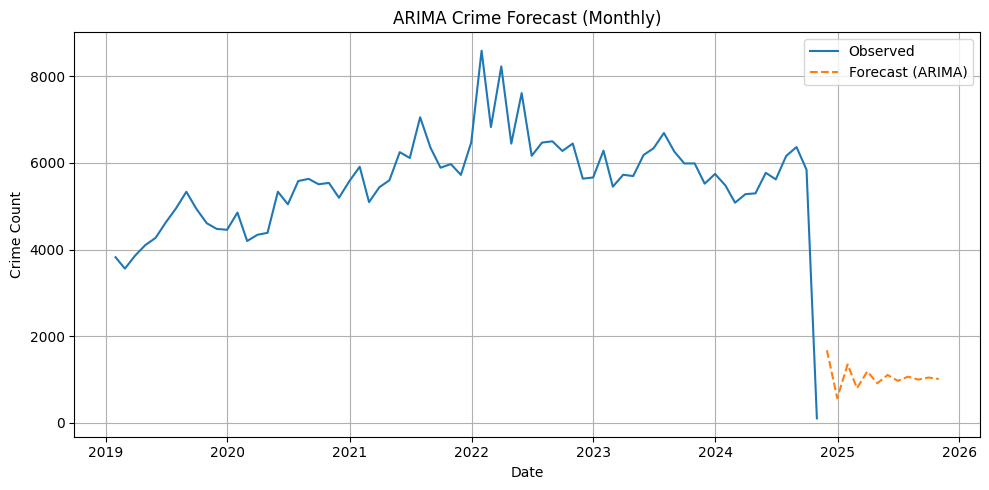

In [ ]:


# Resample by month
monthly_crimes = data.set_index('FIRST_OCCURRENCE_DATE').resample('M').size()

# Fit ARIMA model
model = ARIMA(monthly_crimes, order=(1, 1, 1))  # (p, d, q) can be tuned
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_crimes, label='Observed')
plt.plot(forecast, label='Forecast (ARIMA)', linestyle='--')
plt.title("ARIMA Crime Forecast (Monthly)")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SARIMA Model (Seasonal ARIMA)

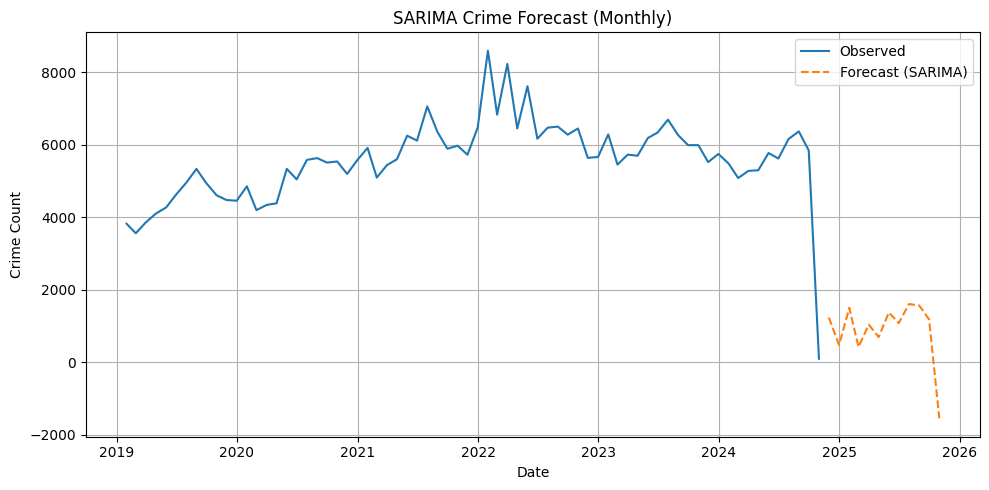

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Seasonal ARIMA: (p, d, q)(P, D, Q, s)
sarima_model = SARIMAX(monthly_crimes, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fit.forecast(steps=12)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_crimes, label='Observed')
plt.plot(sarima_forecast, label='Forecast (SARIMA)', linestyle='--')
plt.title("SARIMA Crime Forecast (Monthly)")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Prophet (by Meta) — Advanced & Flexible

Prophet is an open-source forecasting tool developed by Meta (Facebook) that is designed for handling time series data with strong seasonal effects, multiple trend changes, and missing data. It is highly flexible and suitable for business and real-world applications like crime forecasting, sales, or weather prediction.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6uiejeka/ov05bpbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6uiejeka/used4g21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71716', 'data', 'file=/tmp/tmp6uiejeka/ov05bpbq.json', 'init=/tmp/tmp6uiejeka/used4g21.json', 'output', 'file=/tmp/tmp6uiejeka/prophet_modelpc506apv/prophet_model-20250404003758.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:37:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:37:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

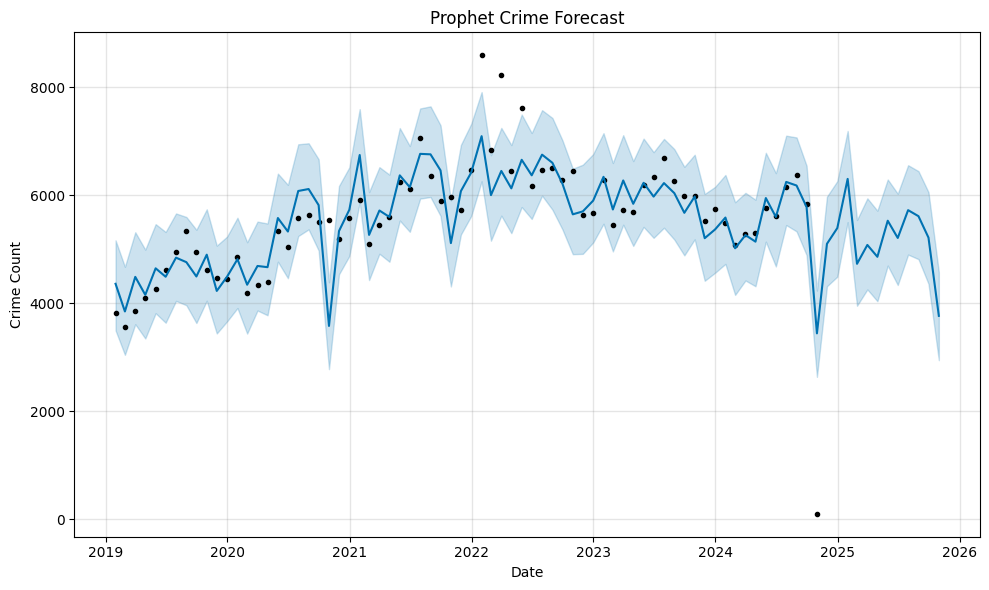

In [ ]:
# pip install prophet
from prophet import Prophet

# Prepare data for Prophet
prophet_df = monthly_crimes.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these names

# Fit model
m = Prophet()
m.fit(prophet_df)

# Future dates
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
plt.title("Prophet Crime Forecast")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.tight_layout()
plt.show()


# Local Moran's

In [ ]:
# Step 1: Loading and preparing data- Already done
# Step 2: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['GEO_LON'], data['GEO_LAT']),
    crs="EPSG:4326"
)

# Step 3: Project to Web Mercator (meters) for distance calculation
gdf = gdf.to_crs(epsg=3857)

# Step 4: Distance-based weights (e.g., 1500 meters)
w = DistanceBand.from_dataframe(gdf, threshold=1500, binary=True, silence_warnings=True)

# Step 5: Drop disconnected points
disconnected = np.array([val == 0 for val in w.cardinalities.values()])
print(f"Disconnected points: {disconnected.sum()}")

gdf_clean = gdf[~disconnected].reset_index(drop=True)
w_clean = DistanceBand.from_dataframe(gdf_clean, threshold=1500, binary=True, silence_warnings=True)

# Step 6: Local Moran’s I
local_moran = Moran_Local(gdf_clean['VICTIM_COUNT'], w_clean)

gdf_clean['Local_I'] = local_moran.Is
gdf_clean['p_sim'] = local_moran.p_sim
gdf_clean['significant'] = gdf_clean['p_sim'] < 0.05
gdf_clean['cluster'] = local_moran.q  # 1=HH, 2=LH, 3=LL, 4=HL

# Step 7: Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
gdf_clean.plot(column='cluster', categorical=True, legend=True, cmap='Set1', ax=ax, markersize=5)
ctx.add_basemap(ax, crs=gdf_clean.crs.to_string())
plt.title("Local Moran's I - Crime Hotspot Clusters (Cleaned)")
plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'gpd' is not defined